In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from pandas import Series
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import (plot_confusion_matrix, plot_roc_curve, f1_score, confusion_matrix, 
                             precision_score, precision_recall_curve, accuracy_score, recall_score, 
                             plot_precision_recall_curve, roc_auc_score, auc, roc_curve)


from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb


from catboost import CatBoostClassifier, cv, Pool

import warnings
warnings.filterwarnings("ignore")

# !pip install xgboost
# !pip install catboost
# !pip install imblearn 

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


# Запишем полезные функции

In [2]:
def all_metrics(y_true, y_pred, y_pred_prob):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dict_metric = {}
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    dict_metric['P'] = [P, np.round(P/(TP+TN+FP+FN)*100,2), 'Дефолтые']
    dict_metric['N'] = [N, np.round(N/(TP+TN+FP+FN)*100,2),'Не дефолтные']
    dict_metric['TP'] = [TP, np.round(TP/(TP+TN+FP+FN)*100,2),'Истинно дефолтные']
    dict_metric['TN'] = [TN, np.round(TN/(TP+TN+FP+FN)*100,2),'Истинно не дефолтные']
    dict_metric['FP'] = [FP, np.round(FP/(TP+TN+FP+FN)*100,2),'Ложно дефолтные']
    dict_metric['FN'] = [FN, np.round(FN/(TP+TN+FP+FN)*100,2),'Ложно не дефолтные']
    dict_metric['Accuracy'] = [accuracy_score(
        y_true, y_pred), '-','Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(
        y_true, y_pred), '-','Точность = TP/(TP+FP)']
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'-', 'Полнота = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'-',
                               'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob), '-','ROC-AUC']

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=[
                                     'Значение', 'Процент', 'Описание метрики'])
    display(temp_df)

In [3]:
def show_heatmap(title, df, font_scale=1):
    """Отображение связи между признаками на тепловой карте"""
    plt.style.use('seaborn-paper')
    fig, ax = plt.subplots(figsize=(10, 10))
    color_text = plt.get_cmap('PuBu')(0.95)
    sns.set(font_scale=font_scale, style='whitegrid')
    plt.subplot(111)
    h = sns.heatmap(df.corr(), annot = True, cmap= "PuBu", center= 0, fmt='.1g')
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    h.set_title(title,  fontsize=16, color = color_text)
    return

In [4]:
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'Модель')
    plt.title('ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [5]:
def show_confusion_matrix(y_true, y_pred):
    """Функция отображает confusion-матрицу"""
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Дефолтный', 'Не дефолтный']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Матрица ошибок")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="brg")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Предсказание', fontsize=14, color = color_text)
    ax.set_xlabel('Истина', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

# Импортируем данные и посмотрим на них

In [6]:
path = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(path+'/train.csv')
df_test = pd.read_csv(path+'/test.csv')
df_sample_sub = pd.read_csv(path+'/sample_submission.csv')

In [7]:
display(df_train.head())
print('\n')
print('df_test: ', df_test.shape)
display(df_test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0




df_test:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [8]:
print(df_train.info()) 
print('\n') 
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [9]:
df_train.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [10]:
df_test.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time
count,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000
mean,54945.647473,39.186002,0.268040,0.166772,-1.904152,2.014471,56.802938,1.573798,2.501087,40835.755729,1.728053,2.765798
std,31706.052195,11.513258,0.788478,0.372777,0.501764,2.296789,13.086646,0.527428,0.683227,43802.180951,1.120686,1.011560
min,4.000000,21.000000,0.000000,0.000000,-3.574197,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000
25%,27744.000000,30.000000,0.000000,0.000000,-2.261909,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000
50%,54657.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000
75%,82322.000000,48.000000,0.000000,0.000000,-1.563957,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000
max,110148.000000,71.000000,30.000000,1.000000,0.188820,47.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000


In [11]:
df_train.isna().sum(), df_test.isna().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

## Объединим

In [12]:
df_train['Sample'] = 1 # помечаем трейн
df_test['Sample'] = 0 # помечаем тест

df = df_train.append(df_test, sort=False).reset_index(drop=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [14]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Sample
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [15]:
df.describe(include = 'object')

,app_date,education,sex,car,car_type,foreign_passport
count,110148,109670,110148,110148,110148,110148
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1491,57998,61836,74290,89140,93721


In [16]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Sample                  0
dtype: int64

In [17]:
df.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1


In [18]:
#Бинарные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#Категориальыне
cat_cols = ['education', 'work_address', 'home_address', 'sna','first_time','region_rating' ]

#Численные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

### Посмотрим на уникальные значения в столбцах, представленных строковыми величинами


In [19]:
cols = df.columns
for col in cols:
    if df[col].dtype == 'O':
        print('Уникальные значения в поле {0} : {1}'.format(col, df[col].unique()), '\n')

Уникальные значения в поле app_date : ['01FEB2014' '12MAR2014' '23JAN2014' '18APR2014' '18FEB2014' '04FEB2014'
 '17MAR2014' '14FEB2014' '10JAN2014' '03FEB2014' '08APR2014' '08JAN2014'
 '19MAR2014' '22JAN2014' '30JAN2014' '11MAR2014' '02FEB2014' '14APR2014'
 '06JAN2014' '24MAR2014' '15APR2014' '28FEB2014' '11FEB2014' '30MAR2014'
 '23MAR2014' '09MAR2014' '02MAR2014' '31JAN2014' '14MAR2014' '26JAN2014'
 '03APR2014' '22MAR2014' '11JAN2014' '17FEB2014' '13FEB2014' '17APR2014'
 '25FEB2014' '10APR2014' '01APR2014' '21APR2014' '20MAR2014' '03MAR2014'
 '25MAR2014' '24FEB2014' '16APR2014' '27FEB2014' '18MAR2014' '19FEB2014'
 '20FEB2014' '31MAR2014' '04MAR2014' '25JAN2014' '07JAN2014' '07MAR2014'
 '26MAR2014' '05FEB2014' '06MAR2014' '08FEB2014' '21JAN2014' '13MAR2014'
 '09JAN2014' '07FEB2014' '29JAN2014' '27JAN2014' '15FEB2014' '29APR2014'
 '04APR2014' '16JAN2014' '07APR2014' '13JAN2014' '21MAR2014' '24JAN2014'
 '27MAR2014' '09FEB2014' '06FEB2014' '22FEB2014' '28JAN2014' '28APR2014'
 '10FEB2014' 

## Data preproc: Education

In [20]:
print('Пропусков в столбце "education" в df: ', 
      len(df[df['education'].isna()])) 

print("Процентная доля: ", round(
    len(df[df['education'].isna()])/len(df)*100, 3), "%")

print("\n")

print('Пропусков в столбце "education" в df_train: ', 
      len(df_train[df_train['education'].isna()])) 

print("Процентная доля: ", round(
    len(df_train[df_train['education'].isna()])/len(df_train)*100, 3), "%")

print("\n")

print('Пропусков в столбце "education" в df_test: ', 
      len(df_test[df_test['education'].isna()])) 

print("Процентная доля: ", round(
    len(df_test[df_test['education'].isna()])/len(df_test)*100, 3), "%")

Пропусков в столбце "education" в df:  478
Процентная доля:  0.434 %


Пропусков в столбце "education" в df_train:  307
Процентная доля:  0.416 %


Пропусков в столбце "education" в df_test:  171
Процентная доля:  0.47 %


In [21]:
df['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

<AxesSubplot:>

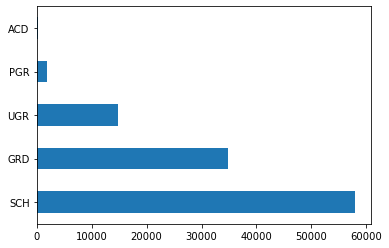

In [22]:
df['education'].value_counts().plot.barh() 

In [23]:
df['education'].fillna('SCH', inplace=True)

## Data Preproc: AppDate


In [24]:
df['app_date'] = pd.to_datetime(df.app_date, format='%d%b%Y') #Обработали дату
df['app_date'].head()

0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]

In [25]:
df['app_date'].dt.year.value_counts() #уникальные года

2014    110148
Name: app_date, dtype: int64

In [26]:
df['app_date'].dt.month.value_counts() #уникальные дни

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

<AxesSubplot:>

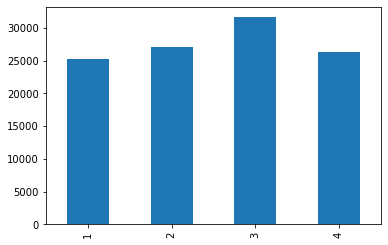

In [27]:
df['app_date'].dt.month.value_counts().plot.bar()

In [28]:
df['app_date'].dt.day.value_counts() #уникальные дни

17    4454
28    4338
18    4321
21    4230
11    4037
24    4035
14    3985
27    3924
15    3916
10    3836
4     3830
3     3818
20    3807
19    3737
22    3704
7     3642
5     3587
12    3559
25    3533
13    3471
16    3444
6     3412
9     3214
26    3141
1     2937
23    2899
30    2774
8     2747
2     2730
29    2553
31    2533
Name: app_date, dtype: int64

## Создадим новые данные

In [29]:
df['app_date_day'] = df.app_date.dt.day  #указатель дня месяца
df['app_date_weekday'] = df.app_date.dt.weekday #указатель дня недели
df['app_date_month'] = df.app_date.dt.month #указатель месяца
df['app_date_year'] = df.app_date.dt.year #указатель года

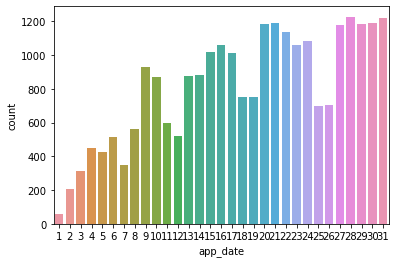

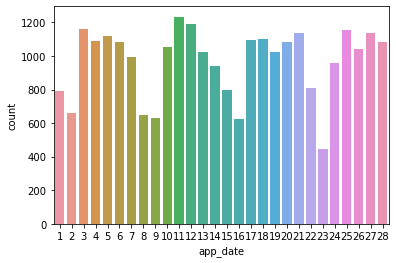

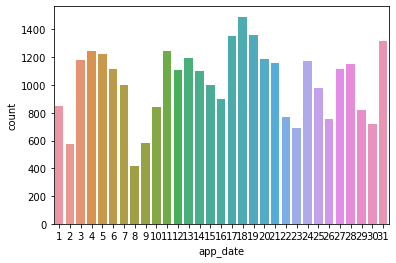

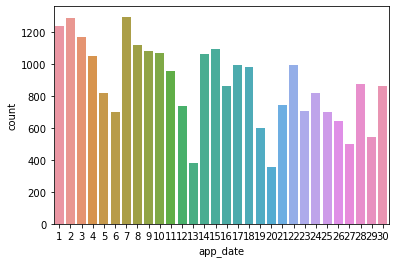

In [30]:
for i in [1,2,3,4]:
    plt.figure()
    sns.countplot(x=df[df.app_date_month == i]['app_date'].dt.day)
    plt.show()

In [31]:
#Зададим точку начала отсчета
start = pd.to_datetime('01/01/2014')
start

Timestamp('2014-01-01 00:00:00')

In [32]:
#Количество дней с начала работы
df['days_from_start'] = (df['app_date'] - start).dt.days
df[df.app_date_month == 1]['days_from_start'].head(10)

3     22
9      9
12     7
15    21
16    29
20     5
28    22
33    30
35    25
39    10
Name: days_from_start, dtype: int64

In [33]:
#Сколько раз встречается дата, что соответствует поданной заявке
df.app_date.value_counts()

2014-03-18    1491
2014-03-19    1363
2014-03-17    1350
2014-03-31    1317
2014-04-07    1296
              ... 
2014-04-20     359
2014-01-07     349
2014-01-03     313
2014-01-02     204
2014-01-01      56
Name: app_date, Length: 120, dtype: int64

In [34]:
#Количество заявок в день
apps_in_def_per_day=df.app_date.value_counts()
df['app_count'] = df.app_date.apply(lambda x: apps_in_def_per_day[x])

#Количетсво дефолтов в день
defaults_in_df_per_day = df['app_date'][df['default'] == 1].value_counts()
df['defaults_per_day']=df.app_date.apply(lambda x:defaults_in_df_per_day[x])

#Доля дефолтов в день
df['share_of_defaults'] = df['defaults_per_day']/df['app_count']

In [35]:
#Сегодняшний день (это плавающая величина, можно вписать любой "важный" день)
datetime.now()

datetime.datetime(2021, 3, 15, 14, 1, 40, 229646)

In [36]:
df['days_to_now']=datetime.now()-df.app_date
df['days_to_now'] = df['days_to_now'].apply(lambda x: x.days)

In [37]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,Sample,app_date_day,app_date_weekday,app_date_month,app_date_year,days_from_start,app_count,defaults_per_day,share_of_defaults,days_to_now
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,1,1,5,2,2014,31,794,63,0.079345,2599
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,...,1,12,2,3,2014,70,1110,88,0.079279,2560
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,...,1,1,5,2,2014,31,794,63,0.079345,2599
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,...,1,23,3,1,2014,22,1060,122,0.115094,2608
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,...,1,18,4,4,2014,107,981,52,0.053007,2523


## Посмотрим на корреляцию новых признаков


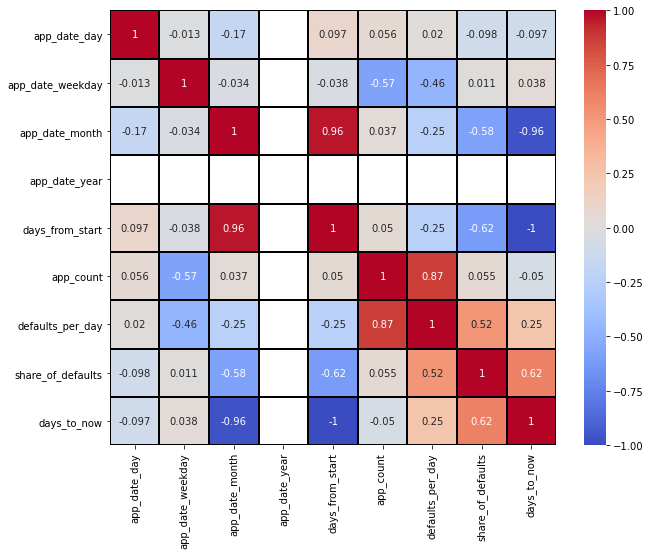

In [38]:
'''The Pearson's correlation coefficient (r) is a measure of linear correlation between two variables. 
It's value lies between -1 and +1, -1 indicating total negative linear correlation,
0 indicating no linear correlation and 1 indicating total positive linear correlation. 
Furthermore, r is invariant under separate changes in location and scale of the two variables, 
implying that for a linear function the angle to the x-axis does not affect r.

To calculate r for two variables X and Y, one divides the covariance of X and Y 
by the product of their standard deviations.'''

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(df.loc[:, ['app_date_day', 'app_date_weekday', 'app_date_month', 'app_date_year', 'days_from_start',
                            'app_count', 'defaults_per_day', 'share_of_defaults', 'days_to_now']].corr(method='pearson'),
                 annot=True, cmap='coolwarm',  linewidths=1, linecolor='black')

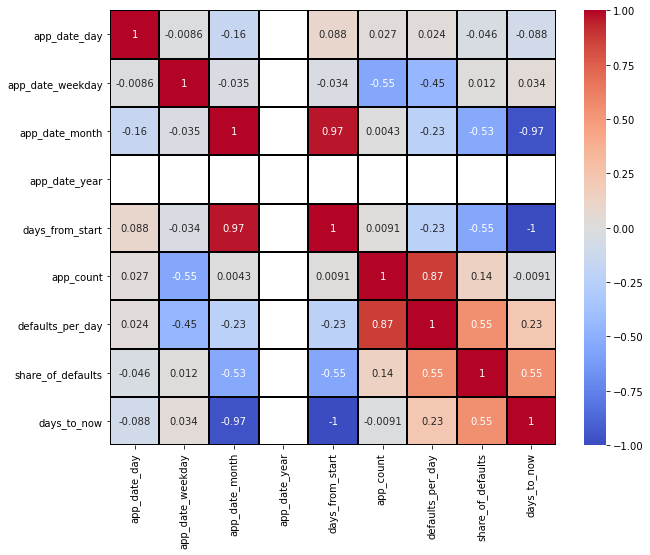

In [39]:
'''The Spearman's rank correlation coefficient (ρ) is a measure of monotonic correlation between two variables,
and is therefore better in catching nonlinear monotonic correlations than Pearson's r.
It's value lies between -1 and +1, -1 indicating total negative monotonic correlation,
0 indicating no monotonic correlation and 1 indicating total positive monotonic correlation.

To calculate ρ for two variables X and Y, one divides the covariance of the rank variables of X and Y 
by the product of their standard deviations.'''

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(df.loc[:, ['app_date_day', 'app_date_weekday', 'app_date_month', 'app_date_year', 'days_from_start',
                            'app_count', 'defaults_per_day', 'share_of_defaults', 'days_to_now']].corr(method = 'spearman'), 
                 annot=True, cmap='coolwarm',  linewidths=1, linecolor='black')

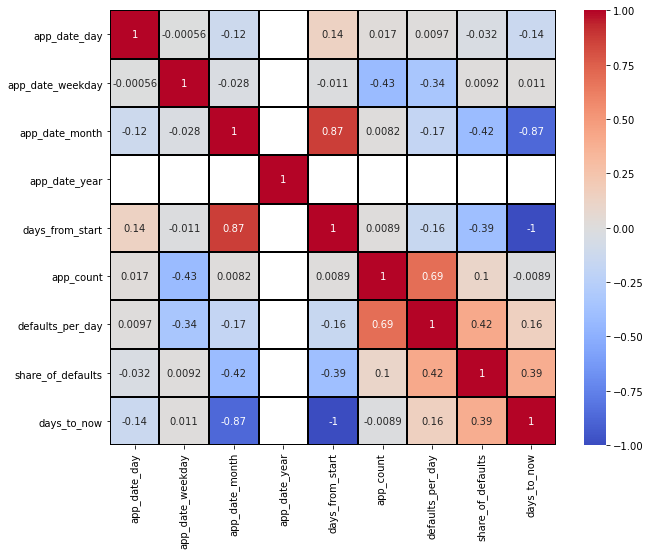

In [40]:
'''Similarly to Spearman's rank correlation coefficient, the Kendall rank correlation coefficient (τ) measures 
ordinal association between two variables. It's value lies between -1 and +1,
-1 indicating total negative correlation, 0 indicating no correlation and 1 indicating total positive correlation.

To calculate τ for two variables X and Y, one determines the number of concordant and discordant pairs of observations.
τ is given by the number of concordant pairs minus the discordant pairs divided by the total number of pairs.'''

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(df.loc[:, ['app_date_day', 'app_date_weekday', 'app_date_month', 'app_date_year', 'days_from_start',
                            'app_count', 'defaults_per_day', 'share_of_defaults', 'days_to_now']].corr(method = 'kendall'), 
                 annot=True, cmap='coolwarm',  linewidths=1, linecolor='black')

При создании признака "год" мы получили лишь одно уникальное значение, тем самым это константа, которая в дальнейшем не поможет нам в построении модели. От этого признака мы избавимся. Колонки "app_date_month", "days_from_start" и "days_to_now" имеют очень сильные корреляции, поэтому из них я оставлю "days_from_start". Колонки "app_count" и "defaults_per_day" тоже скоррелированы. Уберем "defaults_per_day"

In [41]:
df.drop(['app_date', 'app_date_year','days_to_now','app_date_month','defaults_per_day'], axis=1, inplace=True)

In [42]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,sna,first_time,foreign_passport,default,Sample,app_date_day,app_date_weekday,days_from_start,app_count,share_of_defaults
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,4,1,N,0.0,1,1,5,31,794,0.079345
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,4,1,N,0.0,1,12,2,70,1110,0.079279
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,1,4,Y,0.0,1,1,5,31,794,0.079345
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,1,3,N,0.0,1,23,3,22,1060,0.115094
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,1,4,Y,0.0,1,18,4,107,981,0.053007


## Создали новые признаки, надо их правильно разнести по категориям


In [43]:
cols = df.columns
for col in cols:
    if df[col].dtype != 'O':
        print('Уникальные значения в поле {0} : {1}'.format(col,df[col].unique()), '\n')

Уникальные значения в поле client_id : [25905 63161 25887 ... 81852  1971 69044] 

Уникальные значения в поле age : [62 59 25 53 48 27 39 50 54 29 32 30 23 37 36 41 28 58 26 45 44 43 56 40
 34 33 67 38 46 42 35 24 61 21 52 55 49 57 31 64 63 51 22 65 47 66 68 60
 69 70 72 71] 

Уникальные значения в поле decline_app_cnt : [ 0  2  1  3  4  6  5  7  8  9 13 11 19 10 22 33 14 12 15 24 16 21 30 20] 

Уникальные значения в поле good_work : [0 1] 

Уникальные значения в поле score_bki : [-2.00875292 -1.53227621 -1.40814226 ... -0.94075193 -1.24239173
 -1.50754938] 

Уникальные значения в поле bki_request_cnt : [ 1  3  2  0  4  7  5  8  6 13 10 22 12 11 34  9 16 14 26 21 18 24 15 19
 32 17 20 23 27 36 53 25 45 33 28 41 29 46 47 40] 

Уникальные значения в поле region_rating : [50 80 60 40 70 20 30] 

Уникальные значения в поле home_address : [1 2 3] 

Уникальные значения в поле work_address : [2 3 1] 

Уникальные значения в поле income : [ 18000  19000  30000 ...   7350 274000   6020] 

Уникал

<AxesSubplot:xlabel='region_rating', ylabel='count'>

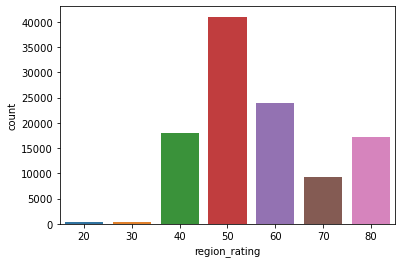

In [44]:
sns.countplot(x=df['region_rating'], data=df)

<AxesSubplot:xlabel='app_date_weekday', ylabel='count'>

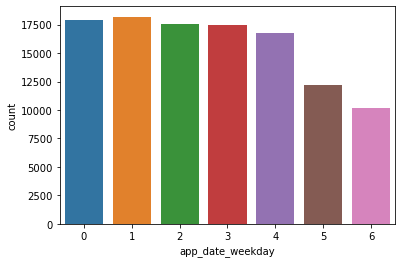

In [45]:
sns.countplot(x=df['app_date_weekday'], data=df)

In [46]:
num_cols +=['days_from_start', 'app_count','share_of_defaults']
cat_cols +=['app_date_weekday', 'app_date_day']

In [47]:
df['score_bki'] = -df['score_bki']

## Числовые признаки

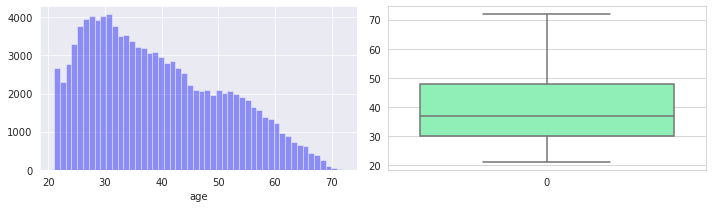

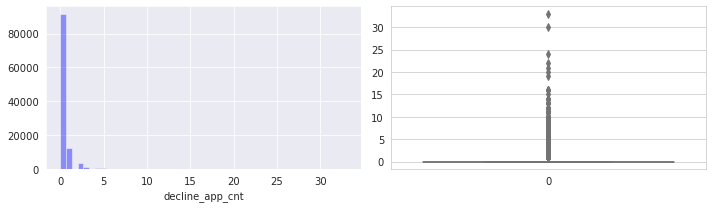

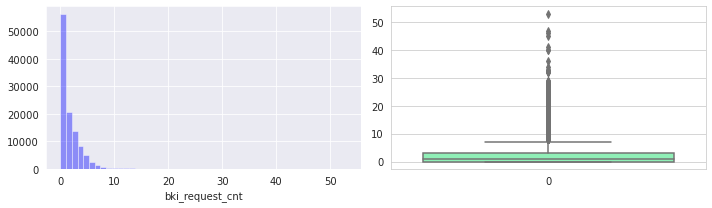

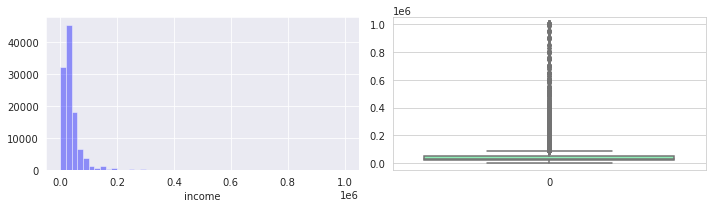

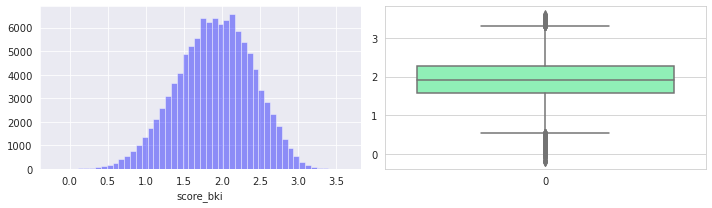

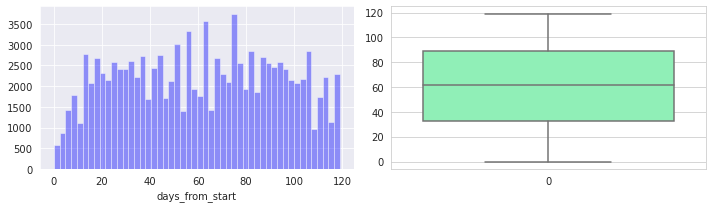

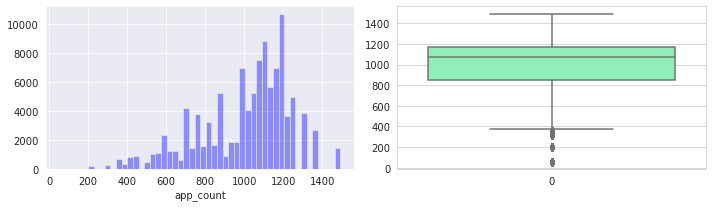

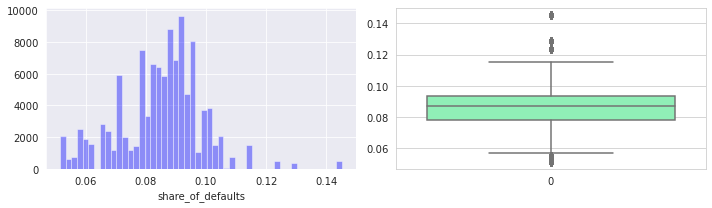

In [48]:
for i in num_cols:
    f = plt.figure(figsize=(10, 3))
    gs = f.add_gridspec(1, 2)
    with sns.axes_style("darkgrid"):
        ax = f.add_subplot(gs[0, 0])
        sns.distplot(df[i], kde = False, rug=False, color='b')

    with sns.axes_style("whitegrid"):
        ax = f.add_subplot(gs[0, 1])
        sns.boxplot(data=df[i], palette='rainbow')

    f.tight_layout()

## Посмотрим на логарифм

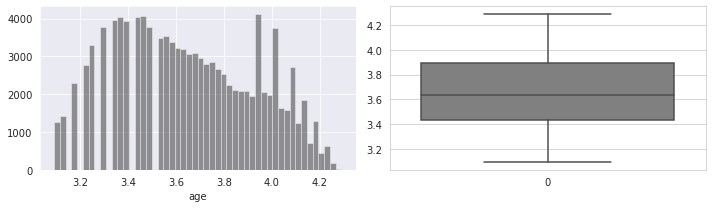

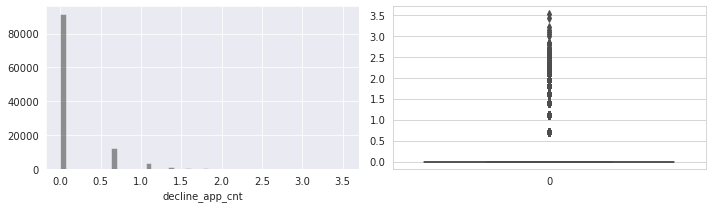

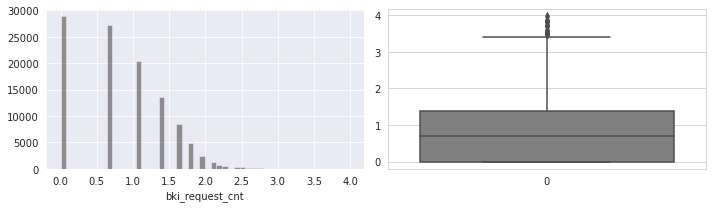

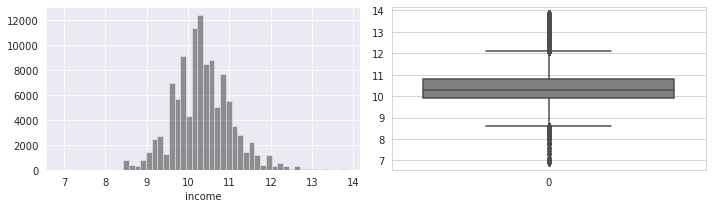

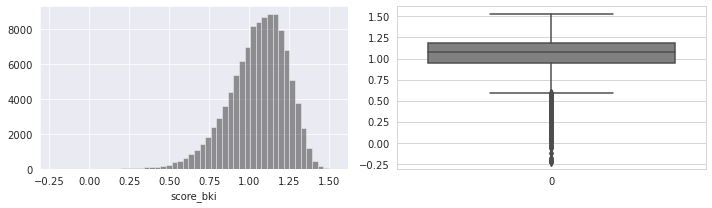

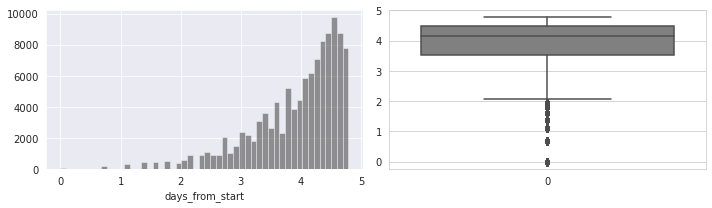

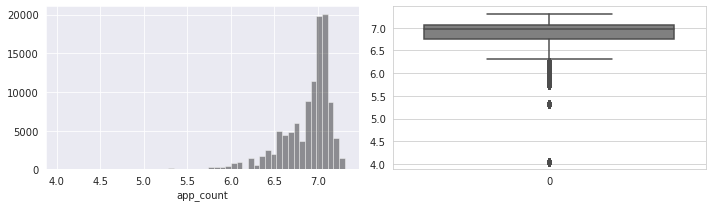

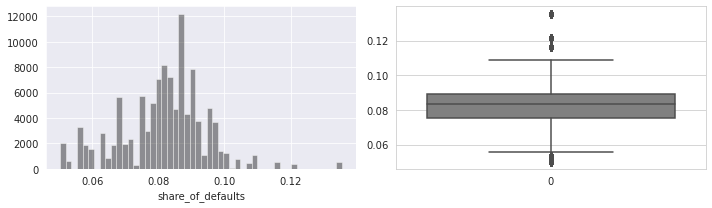

In [49]:
df_log=df.copy()

def log_num_col(column):
    df_log[column]=df_log[column].apply(lambda w: np.log(w+1))
        
for col in num_cols:
    log_num_col(col)
    
for i in num_cols:
    f = plt.figure(figsize=(10, 3))
    gs = f.add_gridspec(1, 2)
    with sns.axes_style("darkgrid"):
        ax = f.add_subplot(gs[0, 0])
        sns.distplot(df_log[i], kde = False, rug=False, color='black')

    with sns.axes_style("whitegrid"):
        ax = f.add_subplot(gs[0, 1])
        sns.boxplot(data=df_log[i], palette='gray')

    f.tight_layout()

## И на квадратный корень

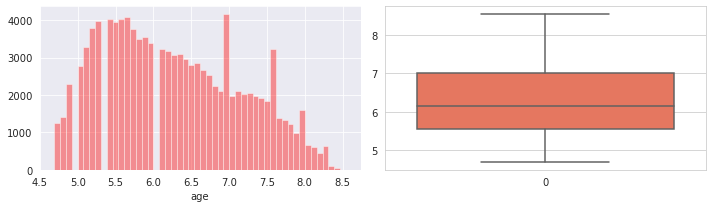

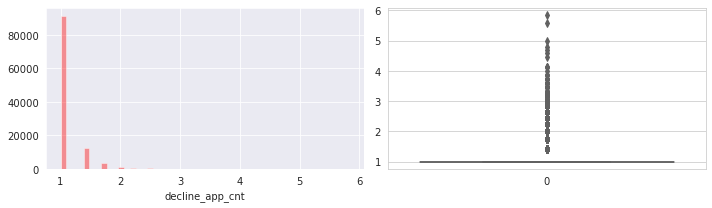

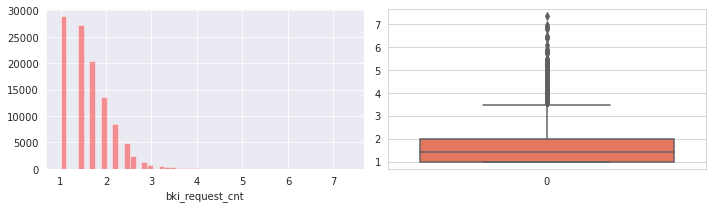

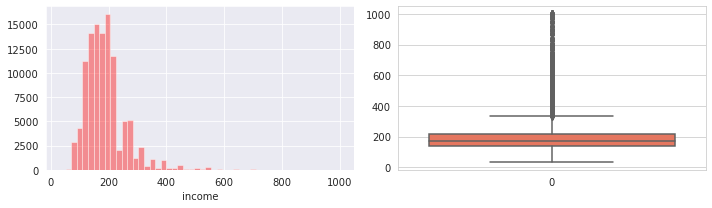

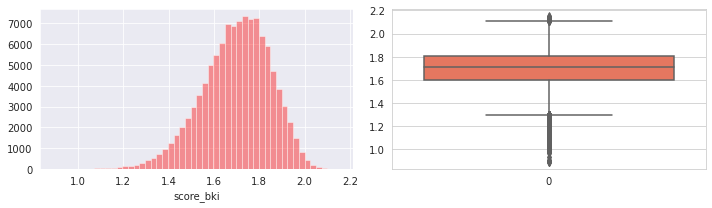

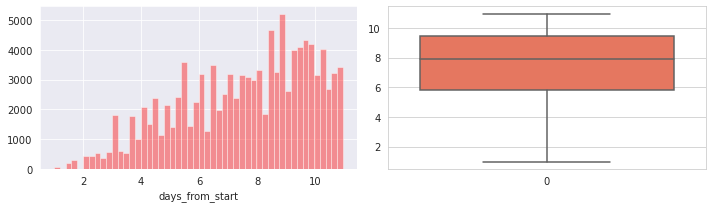

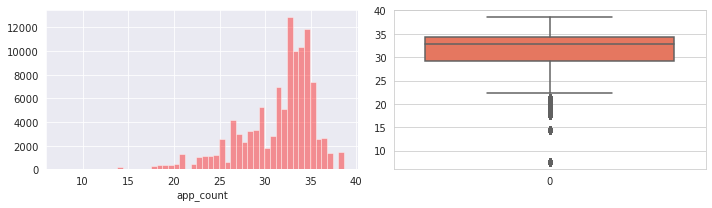

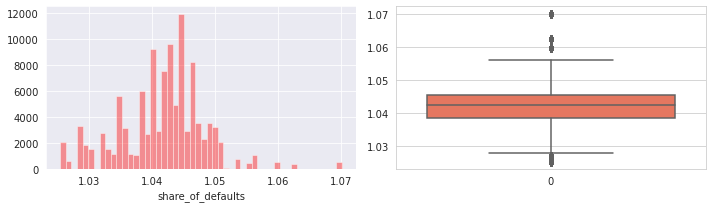

In [50]:
df_sqrt=df.copy()

def sqrt_num_col(column):
    df_sqrt[column]=df_sqrt[column].apply(lambda w: np.sqrt(w+1))
        
for col in num_cols:
    sqrt_num_col(col)
    
for i in num_cols:
    f = plt.figure(figsize=(10, 3))
    gs = f.add_gridspec(1, 2)
    with sns.axes_style("darkgrid"):
        ax = f.add_subplot(gs[0, 0])
        sns.distplot(df_sqrt[i], kde = False, rug=False, color='red')

    with sns.axes_style("whitegrid"):
        ax = f.add_subplot(gs[0, 1])
        sns.boxplot(data=df_sqrt[i], palette='Reds')

    f.tight_layout()

In [51]:
df.income=np.log(df.income+1)
df.age=np.log(df.age+1)
df.bki_reauest_cnt=np.log(df.bki_request_cnt+1)
df.decline_app_cnt=np.sqrt(df.decline_app_cnt)

In [52]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,sna,first_time,foreign_passport,default,Sample,app_date_day,app_date_weekday,days_from_start,app_count,share_of_defaults
0,25905,SCH,M,4.143135,Y,Y,0.000000,0,2.008753,1,...,4,1,N,0.0,1,1,5,31,794,0.079345
1,63161,SCH,F,4.094345,N,N,0.000000,0,1.532276,3,...,4,1,N,0.0,1,12,2,70,1110,0.079279
2,25887,SCH,M,3.258097,Y,N,1.414214,0,1.408142,1,...,1,4,Y,0.0,1,1,5,31,794,0.079345
3,16222,SCH,F,3.988984,N,N,0.000000,0,2.057471,2,...,1,3,N,0.0,1,23,3,22,1060,0.115094
4,101655,GRD,M,3.891820,N,N,0.000000,1,1.244723,1,...,1,4,Y,0.0,1,18,4,107,981,0.053007


## Посмотрим на корреляцию числовых признаков


<AxesSubplot:>

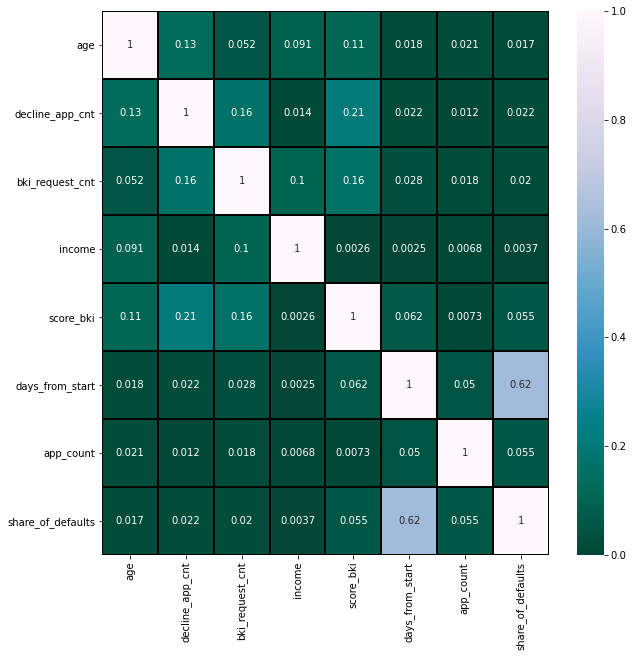

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
correlation = df[num_cols].corr()
sns.heatmap(correlation.abs(), annot=True, linewidth=1,  vmin=0, vmax=1, cmap='PuBuGn_r',  linewidths=1, linecolor='black')

## Непрерывные переменные

<AxesSubplot:title={'center':'Значимость числовых переменных'}>

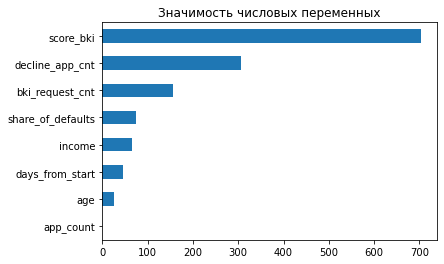

In [54]:
imp_num = Series(f_classif(df[num_cols], df['default']==0)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind = 'barh', title='Значимость числовых переменных')

<AxesSubplot:title={'center':'Значимость числовых переменных'}>

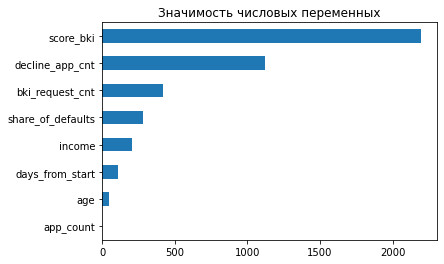

In [55]:
imp_num = Series(f_classif(df[num_cols], df['default']==1)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind = 'barh', title='Значимость числовых переменных')

In [56]:
for x in df.columns:
    if x not in num_cols:
        if x not in bin_cols:
            if x not in cat_cols:
                print(x)

client_id
default
Sample


## Категориальные признаки

In [57]:
# Для бинарных признаков мы будем использовать LabelEncoder
# Все бинарные признаки перекодируемна 0 и 1

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,sna,first_time,foreign_passport,default,Sample,app_date_day,app_date_weekday,days_from_start,app_count,share_of_defaults
0,25905,SCH,1,4.143135,1,1,0.000000,0,2.008753,1,...,4,1,0,0.0,1,1,5,31,794,0.079345
1,63161,SCH,0,4.094345,0,0,0.000000,0,1.532276,3,...,4,1,0,0.0,1,12,2,70,1110,0.079279
2,25887,SCH,1,3.258097,1,0,1.414214,0,1.408142,1,...,1,4,1,0.0,1,1,5,31,794,0.079345
3,16222,SCH,0,3.988984,0,0,0.000000,0,2.057471,2,...,1,3,0,0.0,1,23,3,22,1060,0.115094
4,101655,GRD,1,3.891820,0,0,0.000000,1,1.244723,1,...,1,4,1,0.0,1,18,4,107,981,0.053007


In [58]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

In [59]:
df.education = pd.Series(label_encoder.fit_transform(df['education']))

<AxesSubplot:title={'center':'Значимость бинарных и категориальных признаков'}>

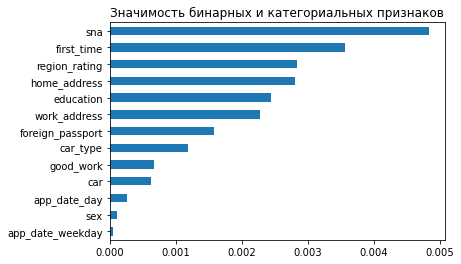

In [60]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default']==1,
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бинарных и категориальных признаков')

<AxesSubplot:>

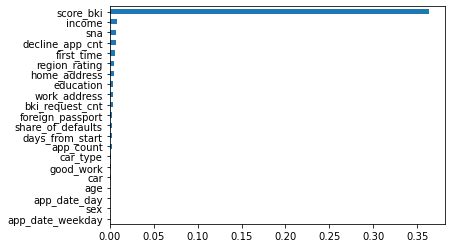

In [61]:
#Значимость джля всех признаков
imp_cat = pd.Series(mutual_info_classif(df[df.Sample == 1][cat_cols+bin_cols+num_cols], df[df.Sample == 1]['default'], 
                                     discrete_features =True), index = cat_cols+bin_cols+num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

## Подготовим данные к обучению

In [62]:
df = pd.get_dummies(df, columns=['sna','first_time','region_rating','home_address','education','work_address','foreign_passport','app_date_weekday'])
df_test_1=df.copy()
df.drop(['client_id'], axis=1, inplace=True)

In [63]:
df0=df.copy()
df1_0=df.copy()
df1=df.copy()
df2=df.copy()
df3=df.copy()
df4=df.copy()
df5=df.copy()
df6=df.copy()
df7=df.copy()
df8_1=df.copy()
df8_2=df.copy()
df8_3=df.copy()
df9_1=df.copy()
df9_2=df.copy()
df10=df.copy()
df11=df.copy()
df_xgb=df.copy()
df_cat=df.copy()

## Оценим состоятельность данных

In [64]:
train_data = df0[df0['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df0[df0['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55)

logreg=LinearSVC().fit(X_train, y_train)
print(logreg.score(X_train, y_train))
print(logreg.score(X_test,y_test))

0.8732702112163147
0.8719512195121951


# Рассмотрим самую наивную модель¶


In [65]:
df.default.value_counts()

0.0    64427
1.0     9372
Name: default, dtype: int64

In [66]:
predict=np.zeros(y_test.shape)
print("Accuracy наивного нуля: ", accuracy_score(y_test,predict))
confusion_matrix(y_test, predict)

Accuracy наивного нуля:  0.8722222222222222


array([[12874,     0],
       [ 1886,     0]])

In [67]:
predict=np.ones(y_test.shape)
print("Accuracy наивной единицы: ", accuracy_score(y_test,predict))
confusion_matrix(y_test, predict)

Accuracy наивной единицы:  0.12777777777777777


array([[    0, 12874],
       [    0,  1886]])

# Модель 1.0 (LogReg)
 

,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,49.000000,0.33,Истинно дефолтные
TN,12810.000000,86.79,Истинно не дефолтные
FP,64.000000,0.43,Ложно дефолтные
FN,1837.000000,12.45,Ложно не дефолтные
Accuracy,0.871206,-,Accuracy=(TP+TN)/(P+N)
Precision,0.433628,-,Точность = TP/(TP+FP)
Recall,0.025981,-,Полнота = TP/P
F1-score,0.049025,-,Среднее гармоническое Precision и Recall


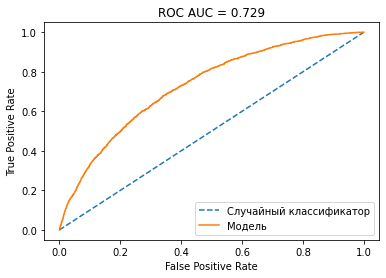

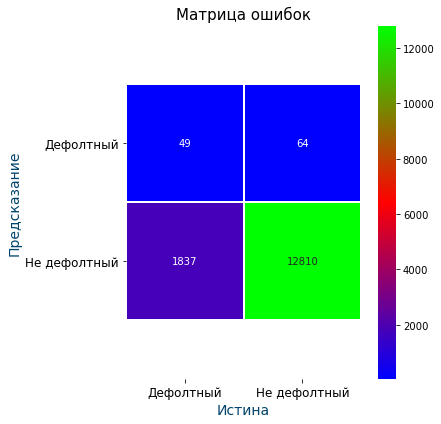

In [68]:
df1_0=df.copy()

train_data = df1_0[df1_0['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df1_0[df1_0['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

model_1_1 = LogisticRegression(random_state=55, max_iter = 1000)

model_1_1.fit(X_train, y_train)

y_pred_prob = model_1_1.predict_proba(X_test)[:,1]
y_pred = model_1_1.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

### Confusion matrix крайне несбалансирована. Мы не предсказываем дефолтных клиентов, многих дефолтных ошибочно определяем в класс не дефолтных. 

# Модель 1.1 (LogReg + MinMaxScaler)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,56.000000,0.38,Истинно дефолтные
TN,12805.000000,86.75,Истинно не дефолтные
FP,69.000000,0.47,Ложно дефолтные
FN,1830.000000,12.40,Ложно не дефолтные
Accuracy,0.871341,-,Accuracy=(TP+TN)/(P+N)
Precision,0.448000,-,Точность = TP/(TP+FP)
Recall,0.029692,-,Полнота = TP/P
F1-score,0.055694,-,Среднее гармоническое Precision и Recall


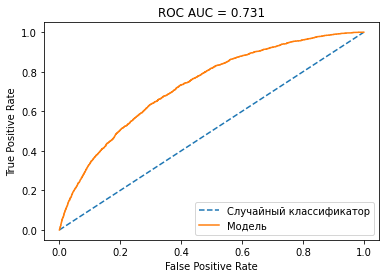

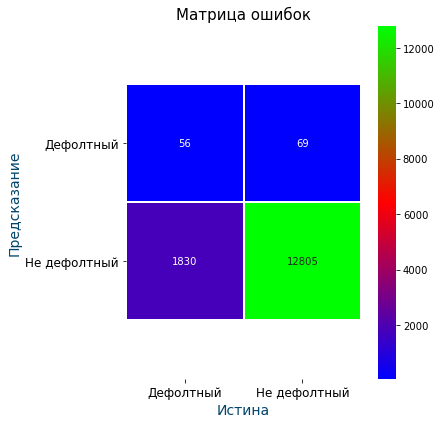

In [69]:
scaler = MinMaxScaler()
df1[num_cols] = scaler.fit_transform(df1[num_cols].values)

train_data = df1[df1['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df1[df1['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

model_1_1 = LogisticRegression(random_state=55, max_iter = 1000)

model_1_1.fit(X_train, y_train)

y_pred_prob = model_1_1.predict_proba(X_test)[:,1]
y_pred = model_1_1.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

# Модель 1.2 (LogReg + StandardScaler)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,57.000000,0.39,Истинно дефолтные
TN,12801.000000,86.73,Истинно не дефолтные
FP,73.000000,0.49,Ложно дефолтные
FN,1829.000000,12.39,Ложно не дефолтные
Accuracy,0.871138,-,Accuracy=(TP+TN)/(P+N)
Precision,0.438462,-,Точность = TP/(TP+FP)
Recall,0.030223,-,Полнота = TP/P
F1-score,0.056548,-,Среднее гармоническое Precision и Recall


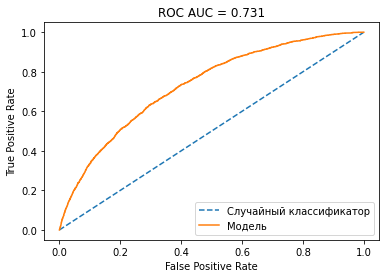

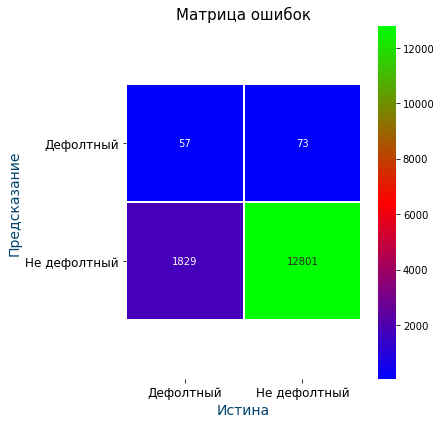

In [70]:
scaler = StandardScaler()
df2[num_cols] = scaler.fit_transform(df2[num_cols].values)

train_data = df2[df2['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df2[df2['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

model_1_2 = LogisticRegression(random_state=55, max_iter = 1000)

model_1_2.fit(X_train, y_train)

y_pred_prob = model_1_2.predict_proba(X_test)[:,1]
y_pred = model_1_2.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

# Модель 1.3 (LogReg + RobustScaler)¶


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,57.000000,0.39,Истинно дефолтные
TN,12801.000000,86.73,Истинно не дефолтные
FP,73.000000,0.49,Ложно дефолтные
FN,1829.000000,12.39,Ложно не дефолтные
Accuracy,0.871138,-,Accuracy=(TP+TN)/(P+N)
Precision,0.438462,-,Точность = TP/(TP+FP)
Recall,0.030223,-,Полнота = TP/P
F1-score,0.056548,-,Среднее гармоническое Precision и Recall


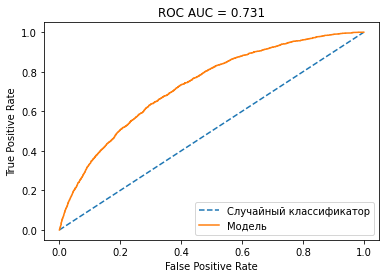

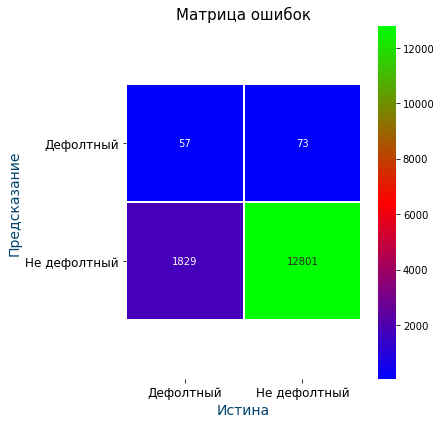

In [71]:
scaler = RobustScaler()
df3[num_cols] = scaler.fit_transform(df3[num_cols].values)

train_data = df3[df3['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df3[df3['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

model_1_3 = LogisticRegression(random_state=55, max_iter = 1000)

model_1_3.fit(X_train, y_train)

y_pred_prob = model_1_3.predict_proba(X_test)[:,1]
y_pred = model_1_3.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Различные скейлеры не дали особого улучшения, однако следует помнить, что они позволяют привести данные к более единообразному виду.

# Model 1.4 (LogReg + RobustScaler +ClassBalance)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,1249.000000,8.46,Истинно дефолтные
TN,8595.000000,58.23,Истинно не дефолтные
FP,4279.000000,28.99,Ложно дефолтные
FN,637.000000,4.32,Ложно не дефолтные
Accuracy,0.666938,-,Accuracy=(TP+TN)/(P+N)
Precision,0.225941,-,Точность = TP/(TP+FP)
Recall,0.662248,-,Полнота = TP/P
F1-score,0.336930,-,Среднее гармоническое Precision и Recall


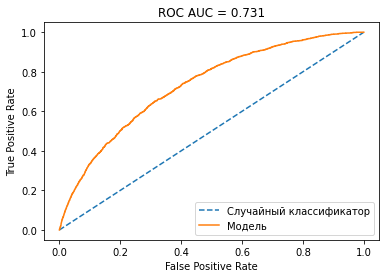

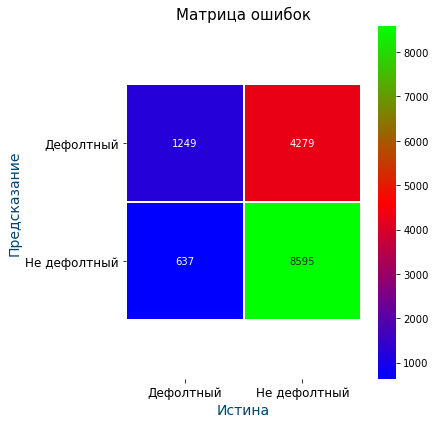

In [72]:
scaler = RobustScaler()
df4[num_cols] = scaler.fit_transform(df4[num_cols].values)

train_data = df4[df4['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df4[df4['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

model_1_4 = LogisticRegression(class_weight='balanced', max_iter = 1000, random_state = 55)

model_1_4.fit(X_train, y_train)

y_pred_prob = model_1_4.predict_proba(X_test)[:,1]
y_pred = model_1_4.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Сделали простейшую балансировку классов, результаты улучшились. По крайней мере мы начали гораздо лучше определять дефолтных клиентов, однако и появились ошибки первого и второго рода. Их нам и надо уменьшить

# Попробуем подобрать гиперпараметры более осознанно


In [73]:
model = LogisticRegression(random_state=52)

iter_max = 1000

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
best_parameters = model.get_params()

for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
print(model)

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 52
	solver: 'newton-cg'
	tol: 0.0001
	verbose: 0
	warm_start: False
LogisticRegression(class_weight='balanced', max_iter=1000, penalty='none',
                   random_state=52, solver='newton-cg')


# Model 1.5 (LogReg + RobustScaler + Hyperparam)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,1249.000000,8.46,Истинно дефолтные
TN,8595.000000,58.23,Истинно не дефолтные
FP,4279.000000,28.99,Ложно дефолтные
FN,637.000000,4.32,Ложно не дефолтные
Accuracy,0.666938,-,Accuracy=(TP+TN)/(P+N)
Precision,0.225941,-,Точность = TP/(TP+FP)
Recall,0.662248,-,Полнота = TP/P
F1-score,0.336930,-,Среднее гармоническое Precision и Recall


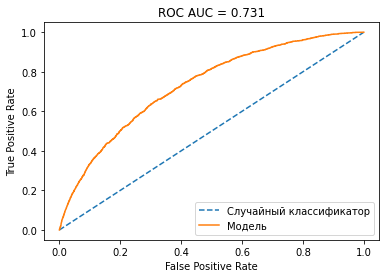

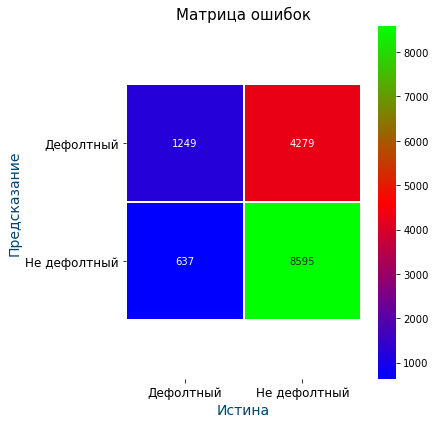

In [74]:
scaler = RobustScaler()
df5[num_cols] = scaler.fit_transform(df5[num_cols].values)

train_data = df5[df5['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df5[df5['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

model_1_5 = LogisticRegression(random_state=52, max_iter=1000,
                             class_weight='balanced', penalty='l1', solver='liblinear')

model_1_5.fit(X_train, y_train)

y_pred_prob = model_1_5.predict_proba(X_test)[:, 1]
y_pred = model_1_5.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

# Model 1.6 (LogRegCV)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,1259.000000,8.53,Истинно дефолтные
TN,8618.000000,58.39,Истинно не дефолтные
FP,4256.000000,28.83,Ложно дефолтные
FN,627.000000,4.25,Ложно не дефолтные
Accuracy,0.669173,-,Accuracy=(TP+TN)/(P+N)
Precision,0.228286,-,Точность = TP/(TP+FP)
Recall,0.667550,-,Полнота = TP/P
F1-score,0.340224,-,Среднее гармоническое Precision и Recall


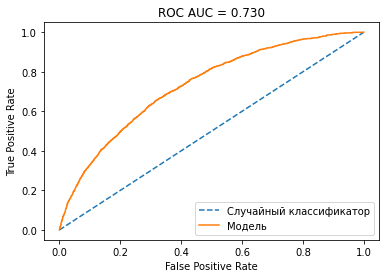

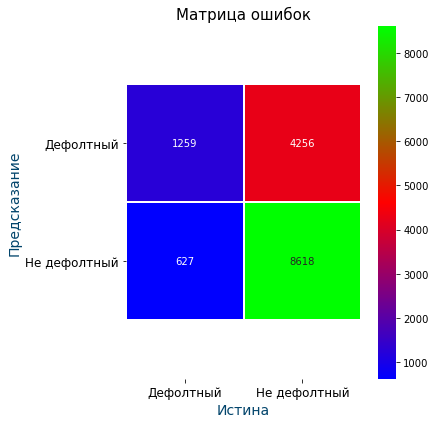

In [75]:
#from sklearn.linear_model import LogisticRegressionCV


scaler = StandardScaler()
df6[num_cols] = scaler.fit_transform(df6[num_cols].values)

train_data = df6[df6['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df6[df6['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

Cs_ = np.logspace(-4, 4, 100)

model_6 = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  class_weight = 'balanced',
  n_jobs = -1,
  random_state = 52,
)

model_6.fit(X_train, y_train)

y_pred_prob = model_6.predict_proba(X_test)[:, 1]
y_pred = model_6.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

# Model 1.7 (SGDClassifier)¶


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,119.000000,0.81,Истинно дефолтные
TN,12707.000000,86.09,Истинно не дефолтные
FP,167.000000,1.13,Ложно дефолтные
FN,1767.000000,11.97,Ложно не дефолтные
Accuracy,0.868970,-,Accuracy=(TP+TN)/(P+N)
Precision,0.416084,-,Точность = TP/(TP+FP)
Recall,0.063097,-,Полнота = TP/P
F1-score,0.109576,-,Среднее гармоническое Precision и Recall


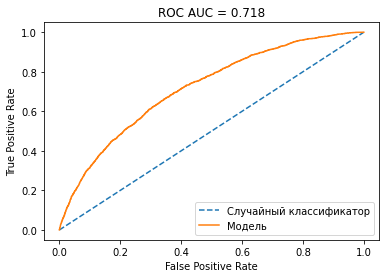

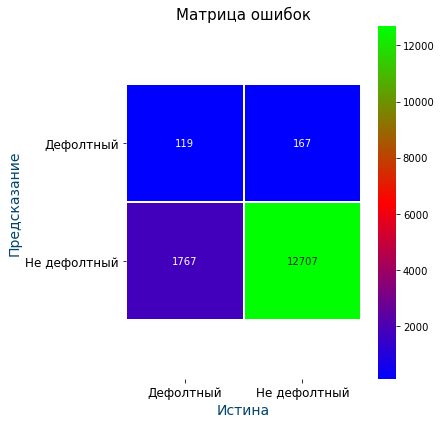

In [76]:
#from sklearn.linear_model import SGDClassifier


scaler = RobustScaler()
df7[num_cols] = scaler.fit_transform(df7[num_cols].values)

train_data = df7[df7['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df7[df7['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

model_7 = SGDClassifier(loss="log", penalty="l1", max_iter=5)
#model_2 = SGDClassifier(loss="modified_huber", penalty="l2", max_iter=5)


model_7.fit(X_train, y_train)

y_pred_prob = model_7.predict_proba(X_test)[:,1]
y_pred = model_7.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Данная модель лишь немного превосходит самую первую, мы по-прежнему не определяем дефолтных клиентов

# **Trees**

# Model 1.8.1 (DesicionTreeClassifier)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,443.000000,3.00,Истинно дефолтные
TN,11058.000000,74.92,Истинно не дефолтные
FP,1816.000000,12.30,Ложно дефолтные
FN,1443.000000,9.78,Ложно не дефолтные
Accuracy,0.779201,-,Accuracy=(TP+TN)/(P+N)
Precision,0.196104,-,Точность = TP/(TP+FP)
Recall,0.234889,-,Полнота = TP/P
F1-score,0.213752,-,Среднее гармоническое Precision и Recall


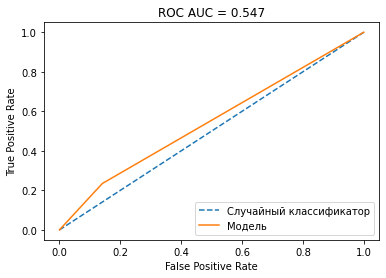

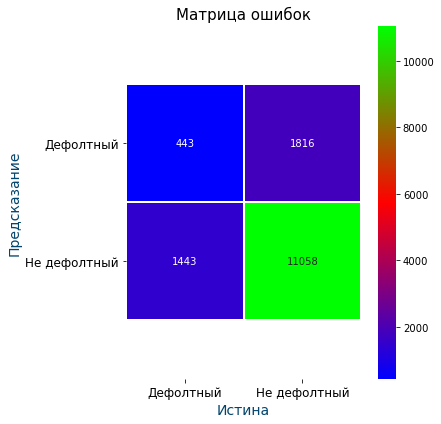

In [77]:
#from sklearn import tree
#from sklearn.tree import DecisionTreeClassifier

scaler = RobustScaler()
df8_1[num_cols] = scaler.fit_transform(df8_1[num_cols].values)

train_data = df8_1[df8_1['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df8_1[df8_1['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

model_181 = tree.DecisionTreeClassifier(random_state=55)
model_181.fit(X_train, y_train)

y_pred_prob = model_181.predict_proba(X_test)[:,1]
y_pred = model_181.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Самое первое дерево едва ли отличается по метрике AUC от простой монетки, хотя accuracy довольно высокая

# Model 1.8.2 (RandomForestClassifier)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,27.000000,0.18,Истинно дефолтные
TN,12835.000000,86.96,Истинно не дефолтные
FP,39.000000,0.26,Ложно дефолтные
FN,1859.000000,12.59,Ложно не дефолтные
Accuracy,0.871409,-,Accuracy=(TP+TN)/(P+N)
Precision,0.409091,-,Точность = TP/(TP+FP)
Recall,0.014316,-,Полнота = TP/P
F1-score,0.027664,-,Среднее гармоническое Precision и Recall


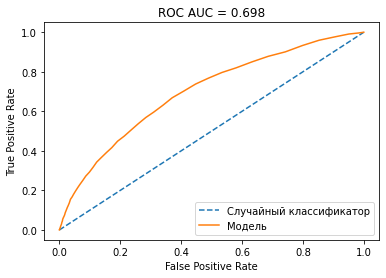

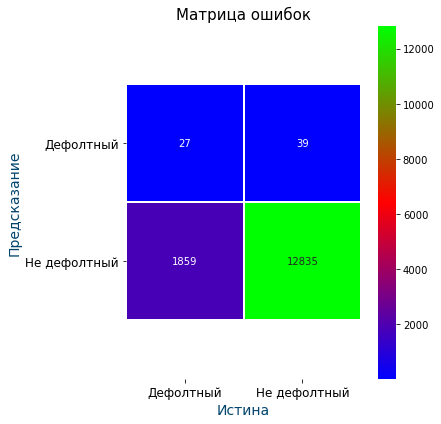

In [78]:
#from sklearn.ensemble import RandomForestClassifier

scaler = RobustScaler()
df8_2[num_cols] = scaler.fit_transform(df8_2[num_cols].values)

train_data = df8_2[df8_2['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df8_2[df8_2['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

model_182 = RandomForestClassifier(random_state=55)
model_182.fit(X_train, y_train)

y_pred_prob = model_182.predict_proba(X_test)[:,1]
y_pred = model_182.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

# Model 1.8.3 (ExtraTreesClassifier)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,52.000000,0.35,Истинно дефолтные
TN,12757.000000,86.43,Истинно не дефолтные
FP,117.000000,0.79,Ложно дефолтные
FN,1834.000000,12.43,Ложно не дефолтные
Accuracy,0.867818,-,Accuracy=(TP+TN)/(P+N)
Precision,0.307692,-,Точность = TP/(TP+FP)
Recall,0.027572,-,Полнота = TP/P
F1-score,0.050608,-,Среднее гармоническое Precision и Recall


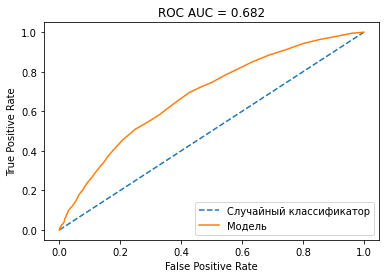

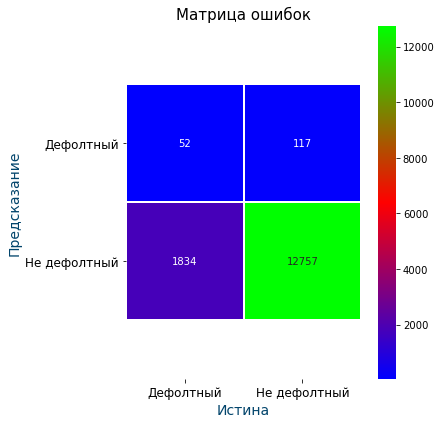

In [79]:
#from sklearn.ensemble import ExtraTreesClassifier

scaler = RobustScaler()
df8_3[num_cols] = scaler.fit_transform(df8_3[num_cols].values)

train_data = df8_3[df8_3['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df8_3[df8_3['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

model_183 = ExtraTreesClassifier(random_state=55)
model_183.fit(X_train, y_train)

y_pred_prob = model_183.predict_proba(X_test)[:,1]
y_pred = model_183.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Данные модели снова не позволяют нам определять дефолтных клиентов. При крайне высокой Accuracy мы все равно имеем не то, что хотелось бы

# Bagging

# Model 1.9.1 (BaggingClassifier + KNeighborsClassifier)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,10.000000,0.07,Истинно дефолтные
TN,12867.000000,87.17,Истинно не дефолтные
FP,7.000000,0.05,Ложно дефолтные
FN,1876.000000,12.71,Ложно не дефолтные
Accuracy,0.872425,-,Accuracy=(TP+TN)/(P+N)
Precision,0.588235,-,Точность = TP/(TP+FP)
Recall,0.005302,-,Полнота = TP/P
F1-score,0.010510,-,Среднее гармоническое Precision и Recall


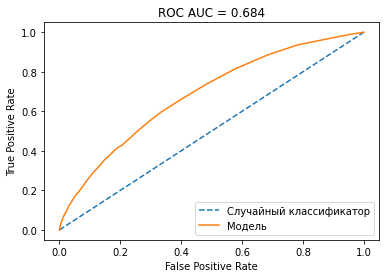

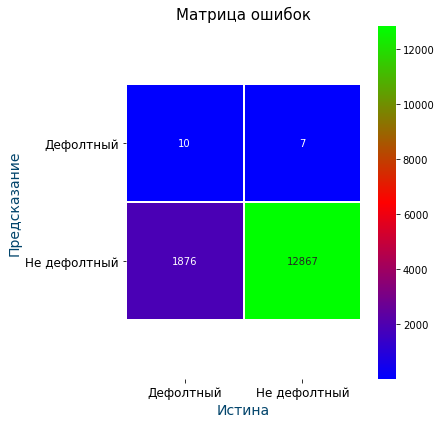

In [80]:
#from sklearn.ensemble import BaggingClassifier
#from sklearn.neighbors import KNeighborsClassifier

df9_1

scaler = StandardScaler()
df9_1[num_cols] = scaler.fit_transform(df9_1[num_cols].values)

train_data = df9_1[df9_1['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df9_1[df9_1['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)


model_191 = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
model_191.fit(X_train, y_train)

y_pred_prob = model_191.predict_proba(X_test)[:,1]
y_pred = model_191.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

# Model 1.9.2 (BaggingClassifier + RandomForest)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,1.000000,0.01,Истинно дефолтные
TN,12869.000000,87.19,Истинно не дефолтные
FP,5.000000,0.03,Ложно дефолтные
FN,1885.000000,12.77,Ложно не дефолтные
Accuracy,0.871951,-,Accuracy=(TP+TN)/(P+N)
Precision,0.166667,-,Точность = TP/(TP+FP)
Recall,0.000530,-,Полнота = TP/P
F1-score,0.001057,-,Среднее гармоническое Precision и Recall


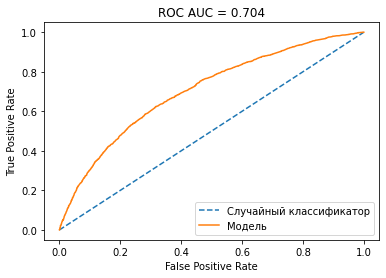

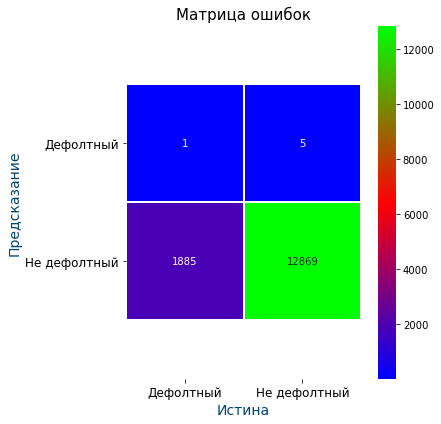

In [81]:
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()
df9_2[num_cols] = scaler.fit_transform(df9_2[num_cols].values)

train_data = df9_2[df9_2['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df9_2[df9_2['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)


model_192 = BaggingClassifier(RandomForestClassifier(),max_samples=0.5, max_features=0.5)
model_192.fit(X_train, y_train)

y_pred_prob = model_192.predict_proba(X_test)[:,1]
y_pred = model_192.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Здесь все те же проблемы

# Boosting

# Model 10 (AdaBoostClassifier)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,75.000000,0.51,Истинно дефолтные
TN,12780.000000,86.59,Истинно не дефолтные
FP,94.000000,0.64,Ложно дефолтные
FN,1811.000000,12.27,Ложно не дефолтные
Accuracy,0.870935,-,Accuracy=(TP+TN)/(P+N)
Precision,0.443787,-,Точность = TP/(TP+FP)
Recall,0.039767,-,Полнота = TP/P
F1-score,0.072993,-,Среднее гармоническое Precision и Recall


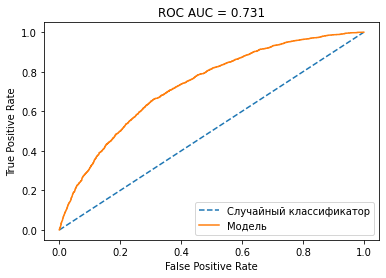

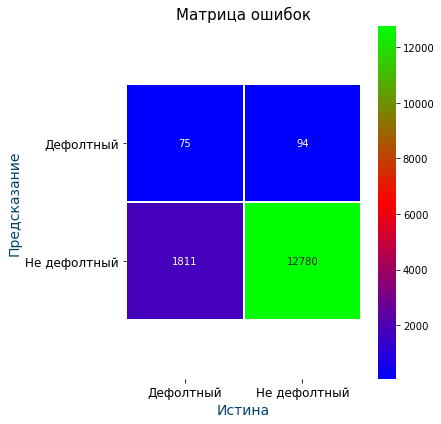

In [82]:
#from sklearn.ensemble import AdaBoostClassifier

scaler = RobustScaler()
df10[num_cols] = scaler.fit_transform(df10[num_cols].values)

train_data = df10[df10['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df10[df10['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)


model_10 = AdaBoostClassifier(n_estimators=100)
model_10.fit(X_train, y_train)

y_pred_prob = model_10.predict_proba(X_test)[:,1]
y_pred = model_10.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

# Model 11 (GradientBoostingClassifier)


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,66.000000,0.45,Истинно дефолтные
TN,12805.000000,86.75,Истинно не дефолтные
FP,69.000000,0.47,Ложно дефолтные
FN,1820.000000,12.33,Ложно не дефолтные
Accuracy,0.872019,-,Accuracy=(TP+TN)/(P+N)
Precision,0.488889,-,Точность = TP/(TP+FP)
Recall,0.034995,-,Полнота = TP/P
F1-score,0.065314,-,Среднее гармоническое Precision и Recall


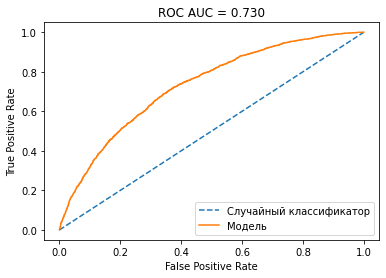

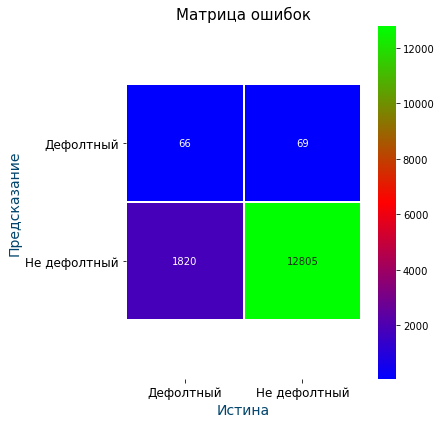

In [83]:
#from sklearn.ensemble import GradientBoostingClassifier

scaler = RobustScaler()
df11[num_cols] = scaler.fit_transform(df11[num_cols].values)

train_data = df11[df11['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df11[df11['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)


model_11 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model_11.fit(X_train, y_train)

y_pred_prob = model_11.predict_proba(X_test)[:,1]
y_pred = model_11.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Те же самые проблемы

# XGBoost

,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,1243.000000,8.42,Истинно дефолтные
TN,8644.000000,58.56,Истинно не дефолтные
FP,4230.000000,28.66,Ложно дефолтные
FN,643.000000,4.36,Ложно не дефолтные
Accuracy,0.669851,-,Accuracy=(TP+TN)/(P+N)
Precision,0.227115,-,Точность = TP/(TP+FP)
Recall,0.659067,-,Полнота = TP/P
F1-score,0.337818,-,Среднее гармоническое Precision и Recall


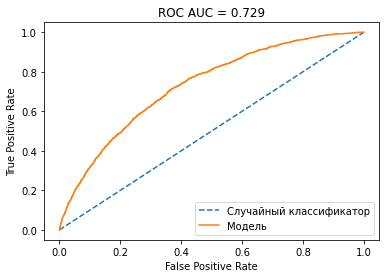

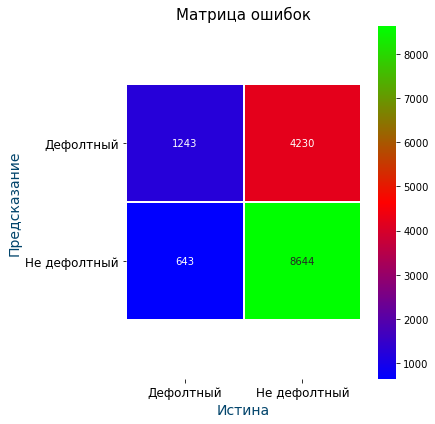

In [84]:
df_xgb=df.copy()

scaler = RobustScaler()
df_xgb[num_cols] = scaler.fit_transform(df_xgb[num_cols].values)

train_data = df_xgb[df_xgb['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df_xgb[df_xgb['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55)

balance_factor = (len(y_train) - sum(y_train))/(sum(y_train))
xg = xgb.XGBClassifier(max_depth = 3, max_bin = 100, scale_pos_weight = balance_factor, eval_metric = 'auc')
xg.fit(X_train, y_train)

y_pred_prob = xg.predict_proba(X_test)[:, 1]
y_pred = xg.predict(X_test)
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Best number of trees = 40


,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,1178.000000,7.98,Истинно дефолтные
TN,9065.000000,61.42,Истинно не дефолтные
FP,3809.000000,25.81,Ложно дефолтные
FN,708.000000,4.80,Ложно не дефолтные
Accuracy,0.693970,-,Accuracy=(TP+TN)/(P+N)
Precision,0.236214,-,Точность = TP/(TP+FP)
Recall,0.624602,-,Полнота = TP/P
F1-score,0.342791,-,Среднее гармоническое Precision и Recall


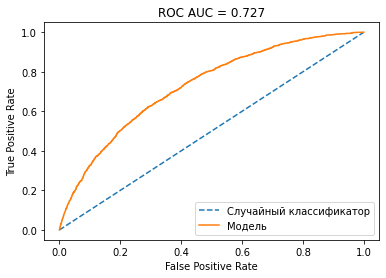

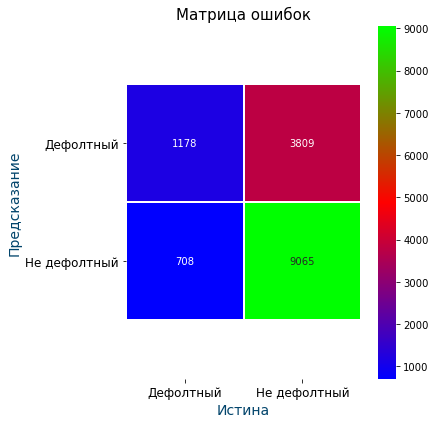

In [85]:
matr = xgb.DMatrix(X_train, label=y_train)
xg = xgb.XGBClassifier(missing=9999999999,
                    max_depth = 7,
                    n_estimators=700,
                    learning_rate=0.1, 
                    nthread=8,
                    subsample=1.0,
                    colsample_bytree=0.5,
                    min_child_weight = 3,
                    seed=42,
                    scale_pos_weight = balance_factor, 
                    eval_metric = 'auc')
xgb_param = xg.get_xgb_params()
cvresult = xgb.cv(xgb_param, matr, num_boost_round=5000, nfold=15, metrics=['auc'],
     early_stopping_rounds=50, stratified=True, seed=42)
print('Best number of trees = {}'.format(cvresult.shape[0]))

xg.set_params(n_estimators=cvresult.shape[0])

xg.fit(X_train, y_train)

y_pred_prob = xg.predict_proba(X_test)[:, 1]
y_pred = xg.predict(X_test)


all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

# Catboost

,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,1115.000000,7.55,Истинно дефолтные
TN,9399.000000,63.68,Истинно не дефолтные
FP,3475.000000,23.54,Ложно дефолтные
FN,771.000000,5.22,Ложно не дефолтные
Accuracy,0.712331,-,Accuracy=(TP+TN)/(P+N)
Precision,0.242919,-,Точность = TP/(TP+FP)
Recall,0.591198,-,Полнота = TP/P
F1-score,0.344348,-,Среднее гармоническое Precision и Recall


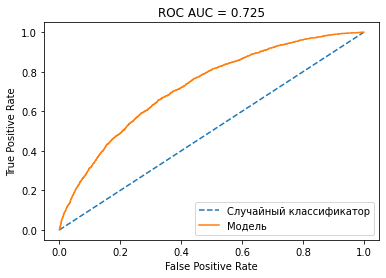

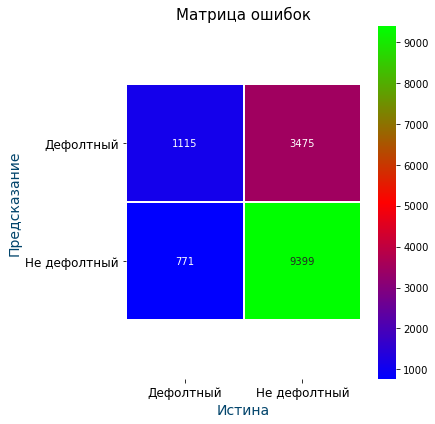

In [86]:
df_cat=df.copy()

scaler = RobustScaler()
df_cat[num_cols] = scaler.fit_transform(df_cat[num_cols].values)

train_data = df_cat[df_cat['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df_cat[df_cat['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values
X = train_data.drop(['default'], axis=1).values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55)

#from catboost import CatBoostClassifier, cv, Pool

balance_factor = (len(y_train) - sum(y_train))/(sum(y_train))
ctbst = CatBoostClassifier(task_type = 'CPU', 
                              verbose = False, 
                              class_weights = [1, balance_factor])
ctbst.fit(X_train, y_train)

y_pred_prob = ctbst.predict_proba(X_test)[:, 1]
y_pred = ctbst.predict(X_test)


all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

In [87]:
ctbst = CatBoostClassifier(task_type = 'CPU', 
                              verbose = False, 
                              class_weights = [1, balance_factor])
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = ctbst.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5980045702
bestIteration = 555

0:	loss: 0.5980046	best: 0.5980046 (0)	total: 14.5s	remaining: 6m 59s

bestTest = 0.5986912072
bestIteration = 152

1:	loss: 0.5986912	best: 0.5980046 (0)	total: 28.6s	remaining: 6m 39s

bestTest = 0.5975071285
bestIteration = 700

2:	loss: 0.5975071	best: 0.5975071 (2)	total: 46.5s	remaining: 6m 58s

bestTest = 0.5996484686
bestIteration = 193

3:	loss: 0.5996485	best: 0.5975071 (2)	total: 1m 1s	remaining: 6m 37s

bestTest = 0.5978860388
bestIteration = 662

4:	loss: 0.5978860	best: 0.5975071 (2)	total: 1m 16s	remaining: 6m 20s

bestTest = 0.5974647654
bestIteration = 162

5:	loss: 0.5974648	best: 0.5974648 (5)	total: 1m 30s	remaining: 6m 2s

bestTest = 0.5977875931
bestIteration = 604

6:	loss: 0.5977876	best: 0.5974648 (5)	total: 1m 45s	remaining: 5m 47s

bestTest = 0.5983296189
bestIteration = 205

7:	loss: 0.5983296	best: 0.5974648 (5)	total: 2m	remaining: 5m 31s

bestTest = 0.59736373
bestIteration = 607

8:	loss: 0.5973637	best: 0.59

,Значение,Процент,Описание метрики
P,1886.000000,12.78,Дефолтые
N,12874.000000,87.22,Не дефолтные
TP,1194.000000,8.09,Истинно дефолтные
TN,8995.000000,60.94,Истинно не дефолтные
FP,3879.000000,26.28,Ложно дефолтные
FN,692.000000,4.69,Ложно не дефолтные
Accuracy,0.690312,-,Accuracy=(TP+TN)/(P+N)
Precision,0.235364,-,Точность = TP/(TP+FP)
Recall,0.633086,-,Полнота = TP/P
F1-score,0.343153,-,Среднее гармоническое Precision и Recall


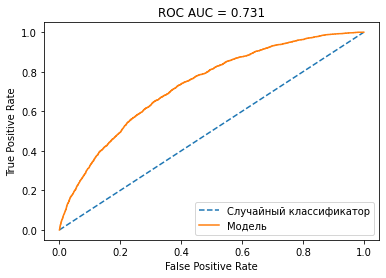

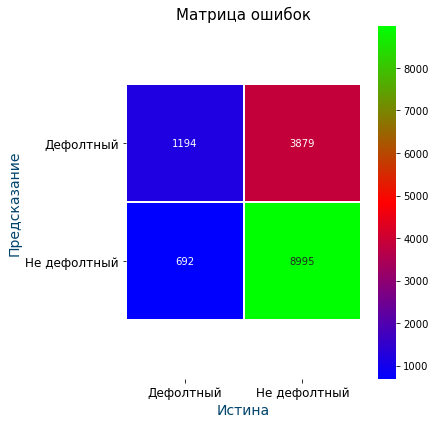

In [88]:
ctbst.fit(X_train, y_train)

y_pred_prob = ctbst.predict_proba(X_test)[:, 1]
y_pred = ctbst.predict(X_test)


all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Это уже были серьезные модели, но встает большая проблема не дефолтных клиентов, определенных как дефолтные, то есть банк рискует не выдать им кредит, а значит и не получить прибыль 

# Попробуем эксперимента ради OverSampling и UnderSampling


In [89]:
df_over=df.copy()
df_under=df.copy()

In [90]:
# попробуем oversampling для устранения дисбаланса
df_over_0 = df_over.query('default == 0')
df_over_1 = df_over.query('default == 1')
koeff = int(len(df_over_0)/len(df_over_1))
for i in range(koeff):
    df_over = df_over.append(df_over_1).reset_index(drop=True)  # объединяем

In [91]:
df_over['default'].value_counts()

1.0    65604
0.0    64427
Name: default, dtype: int64

,Значение,Процент,Описание метрики
P,13118.000000,50.44,Дефолтые
N,12889.000000,49.56,Не дефолтные
TP,8807.000000,33.86,Истинно дефолтные
TN,8694.000000,33.43,Истинно не дефолтные
FP,4195.000000,16.13,Ложно дефолтные
FN,4311.000000,16.58,Ложно не дефолтные
Accuracy,0.672934,-,Accuracy=(TP+TN)/(P+N)
Precision,0.677357,-,Точность = TP/(TP+FP)
Recall,0.671368,-,Полнота = TP/P
F1-score,0.674349,-,Среднее гармоническое Precision и Recall


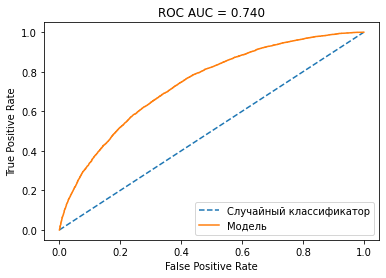

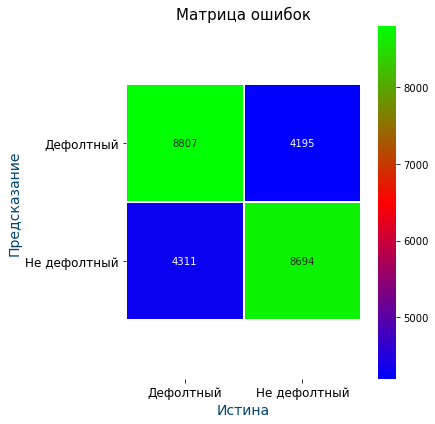

In [92]:
scaler = RobustScaler()
df_over[num_cols] = scaler.fit_transform(df_over[num_cols].values)

train_data = df_over[df_over['Sample'] == 1].drop(['Sample'], axis=1)
test_data = df_over[df_over['Sample'] == 0].drop(['Sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

model_over = LogisticRegression(random_state=52, max_iter=1000,
                             class_weight='balanced', penalty='l1', solver='liblinear')

model_over.fit(X_train, y_train)

y_pred_prob = model_over.predict_proba(X_test)[:,1]
y_pred = model_over.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

,Значение,Процент,Описание метрики
P,2733.000000,12.41,Дефолтые
N,19297.000000,87.59,Не дефолтные
TP,1737.000000,7.88,Истинно дефолтные
TN,18066.000000,82.01,Истинно не дефолтные
FP,1231.000000,5.59,Ложно дефолтные
FN,996.000000,4.52,Ложно не дефолтные
Accuracy,0.898911,-,Accuracy=(TP+TN)/(P+N)
Precision,0.585243,-,Точность = TP/(TP+FP)
Recall,0.635565,-,Полнота = TP/P
F1-score,0.609367,-,Среднее гармоническое Precision и Recall


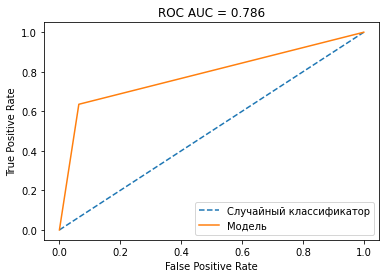

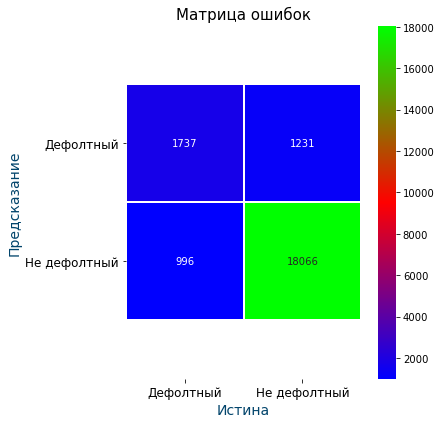

In [93]:
from sklearn.tree import DecisionTreeClassifier

df_0=df.copy()
df_0_0=df_0[df_0['Sample'] == 0]
df_0_1=df_0[df_0['Sample'] == 1]
df_0_cut=df_0.iloc[:36349]
df_res = pd.concat([df_0_cut, df_0_1], axis =0)

y = df_res.default.values           
X = df_res.drop(['default'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

clf = DecisionTreeClassifier(random_state=55).fit(X_train, y_train)
#clf = LogisticRegression(random_state=55, max_iter = 1000)

clf.fit(X_train, y_train)

y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

# Submission

In [94]:
scaler = RobustScaler()
df_test_1[num_cols] = scaler.fit_transform(df_test_1[num_cols].values)

train_data = df_test_1[df_test_1['Sample'] == 1].drop(['client_id','Sample'], axis=1)
test_data = df_test_1[df_test_1['Sample'] == 0].drop(['client_id','Sample'], axis=1)

X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 49), (73799, 49), (73799, 48), (73799,), (36349, 48))

In [95]:
# C: 1.0
# 	class_weight: 'balanced'
# 	dual: False
# 	fit_intercept: True
# 	intercept_scaling: 1
# 	l1_ratio: None
# 	max_iter: 1000
# 	multi_class: 'auto'
# 	n_jobs: None
# 	penalty: 'none'
# 	random_state: 52
# 	solver: 'newton-cg'
# 	tol: 0.0001
# 	verbose: 0
# 	warm_start: False

In [96]:
last_model = LogisticRegression(random_state=52, max_iter=1000,
                             class_weight='balanced', penalty='none', solver='newton-cg', dual=False, fit_intercept=True,
                               l1_ratio=None, multi_class='auto', n_jobs=None, tol=0.0001, verbose=0, warm_start=False )

last_model.fit(X_train, y_train)
y_pred_prob = last_model.predict_proba(X_test)[:,1]
y_pred = last_model.predict(X_test)

In [97]:
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)
submit

,client_id,default
0,74835,0.210303
1,17527,0.736729
2,75683,0.324891
3,26883,0.405574
4,28862,0.148898
...,...,...
36344,83775,0.781671
36345,106254,0.082204
36346,81852,0.794580
36347,1971,0.679005
